# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [3]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.003998756408691406 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.010998964309692383ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [2]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.12264108657836914ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

## Relabeling and normilizing

In [3]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='fear')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+02, tolerance: 6.656e-02

Text(0, 0.5, 'Coeffs')

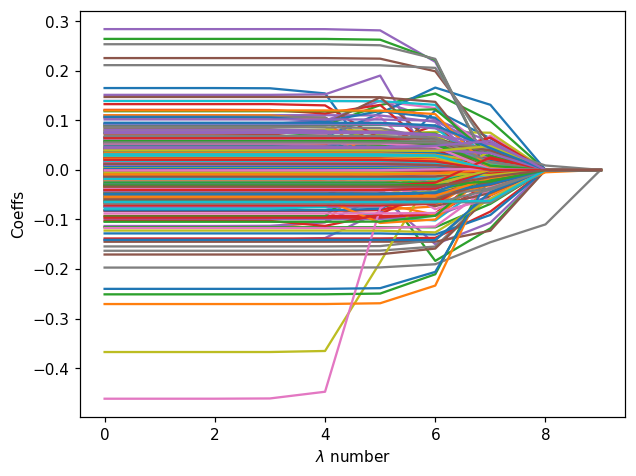

In [4]:
Lasso_model = linear_model.Lasso()
Npt = 10
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [5]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [6]:
np.save('data/Lasso_Ranking_fear_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_fear_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.6899
Iter =  2  AUC = 0.7005
Iter =  3  AUC = 0.7099
Iter =  4  AUC = 0.7278
Iter =  10  AUC = 0.7388
Iter =  11  AUC = 0.7476
Iter =  17  AUC = 0.7582
Iter =  18  AUC = 0.7584
Iter =  19  AUC = 0.7792
Iter =  28  AUC = 0.7817
Iter =  29  AUC = 0.7905
Iter =  35  AUC = 0.7993
Iter =  43  AUC = 0.8035
Iter =  44  AUC = 0.8105
Iter =  45  AUC = 0.8221
Iter =  61  AUC = 0.8237
Iter =  82  AUC = 0.8417
Iter =  89  AUC = 0.8448
Iter =  109  AUC = 0.8466
Iter =  110  AUC = 0.8508
auc_best = 0.85076122


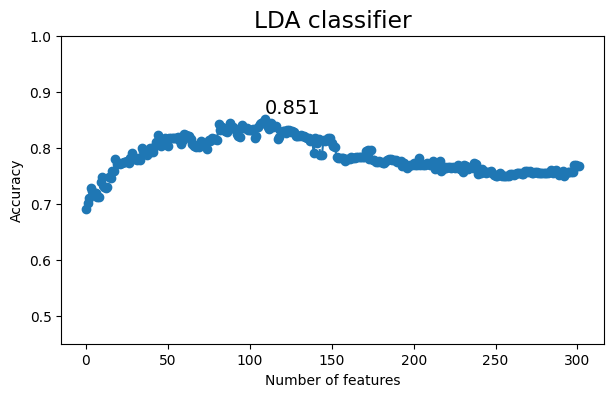

In [7]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [8]:
print('best auc (LDA) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

best auc (LDA) =  0.850761217948718 Number of features =  109


# Backward step selection

In [9]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)
         
         print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [12]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND
Iter #0: 0.813 <-> 0.851
Iter #1: 0.849 <-> 0.851
Iter #2: 0.815 <-> 0.851
Iter #3: 0.837 <-> 0.851
Iter #4: 0.842 <-> 0.851
Iter #5: 0.845 <-> 0.851
Iter #6: 0.831 <-> 0.851
Iter #7: 0.846 <-> 0.851
Iter #8: 0.846 <-> 0.851
Iter #9: 0.839 <-> 0.851
Iter #10: 0.848 <-> 0.851
Iter #11: 0.846 <-> 0.851
Iter #12: 0.787 <-> 0.851
Iter #13: 0.834 <-> 0.851
Iter #14: 0.848 <-> 0.851
Iter #15: 0.846 <-> 0.851
Iter #16: 0.839 <-> 0.851
Iter #17: 0.834 <-> 0.851
Iter #18: 0.839 <-> 0.851
Iter #19: 0.835 <-> 0.851
Iter #20: 0.849 <-> 0.851
Iter #21: 0.824 <-> 0.851
Iter #22: 0.828 <-> 0.851
Iter #23: 0.830 <-> 0.851
Iter #24: 0.835 <-> 0.851
Iter #25: 0.850 <-> 0.851
Iter #26: 0.848 <-> 0.851
Iter #27: 0.821 <-> 0.851
Iter #28: 0.819 <-> 0.851
Iter #29: 0.784 <-> 0.851
Iter #30: 0.846 <-> 0.851
Iter #31: 0.844 <-> 0.851
Iter #32: 0.829 <-> 0.851
Iter #33: 0.850 <-> 0.851
Iter #34: 0.818 <-> 0.851
Iter #35: 0.852 <-> 0.851
Iter #36: 0.850 <-> 0.851
Iter #37: 0.826 <-> 0.851
Iter #38: 0.

Iter #93: 0.850 <-> 0.856
Iter #94: 0.848 <-> 0.856
Iter #95: 0.851 <-> 0.856
Iter #96: 0.790 <-> 0.856
Iter #97: 0.850 <-> 0.856
Iter #98: 0.852 <-> 0.856
Iter #99: 0.852 <-> 0.856
Iter #100: 0.817 <-> 0.856
Iter #101: 0.853 <-> 0.856
Iter #102: 0.791 <-> 0.856
Iter #103: 0.851 <-> 0.856
Iter #104: 0.849 <-> 0.856
Iter #105: 0.847 <-> 0.856
Iter #106: 0.851 <-> 0.856
Iter #107: 0.815 <-> 0.856
Withdraw feature #10, added accracy 0
NEW ROUND
Iter #0: 0.789 <-> 0.856
Iter #1: 0.817 <-> 0.856
Iter #2: 0.845 <-> 0.856
Iter #3: 0.853 <-> 0.856
Iter #4: 0.853 <-> 0.856
Iter #5: 0.850 <-> 0.856
Iter #6: 0.823 <-> 0.856
Iter #7: 0.843 <-> 0.856
Iter #8: 0.845 <-> 0.856
Iter #9: 0.857 <-> 0.856
Iter #10: 0.854 <-> 0.856
Iter #11: 0.847 <-> 0.856
Iter #12: 0.844 <-> 0.856
Iter #13: 0.844 <-> 0.856
Iter #14: 0.839 <-> 0.856
Iter #15: 0.830 <-> 0.856
Iter #16: 0.859 <-> 0.856
Iter #17: 0.826 <-> 0.856
Iter #18: 0.842 <-> 0.856
Iter #19: 0.778 <-> 0.856
Iter #20: 0.831 <-> 0.856
Iter #21: 0.856 <-

Iter #82: 0.835 <-> 0.857
Iter #83: 0.857 <-> 0.857
Iter #84: 0.852 <-> 0.857
Iter #85: 0.792 <-> 0.857
Iter #86: 0.785 <-> 0.857
Iter #87: 0.860 <-> 0.857
Iter #88: 0.787 <-> 0.857
Iter #89: 0.825 <-> 0.857
Iter #90: 0.855 <-> 0.857
Iter #91: 0.853 <-> 0.857
Iter #92: 0.854 <-> 0.857
Iter #93: 0.824 <-> 0.857
Iter #94: 0.863 <-> 0.857
Iter #95: 0.858 <-> 0.857
Iter #96: 0.860 <-> 0.857
Iter #97: 0.821 <-> 0.857
Iter #98: 0.854 <-> 0.857
Iter #99: 0.781 <-> 0.857
Iter #100: 0.862 <-> 0.857
Iter #101: 0.857 <-> 0.857
Iter #102: 0.855 <-> 0.857
Iter #103: 0.852 <-> 0.857
Iter #104: 0.821 <-> 0.857
Withdraw feature #19, added accracy 0
NEW ROUND
Iter #0: 0.784 <-> 0.860
Iter #1: 0.850 <-> 0.860
Iter #2: 0.848 <-> 0.860
Iter #3: 0.844 <-> 0.860
Iter #4: 0.856 <-> 0.860
Iter #5: 0.856 <-> 0.860
Iter #6: 0.825 <-> 0.860
Iter #7: 0.857 <-> 0.860
Iter #8: 0.832 <-> 0.860
Iter #9: 0.857 <-> 0.860
Iter #10: 0.850 <-> 0.860
Iter #11: 0.832 <-> 0.860
Iter #12: 0.820 <-> 0.860
Iter #13: 0.778 <-> 0

Iter #81: 0.849 <-> 0.863
Iter #82: 0.781 <-> 0.863
Iter #83: 0.787 <-> 0.863
Iter #84: 0.822 <-> 0.863
Iter #85: 0.861 <-> 0.863
Iter #86: 0.829 <-> 0.863
Iter #87: 0.851 <-> 0.863
Iter #88: 0.863 <-> 0.863
Iter #89: 0.859 <-> 0.863
Iter #90: 0.847 <-> 0.863
Iter #91: 0.853 <-> 0.863
Iter #92: 0.858 <-> 0.863
Iter #93: 0.863 <-> 0.863
Iter #94: 0.815 <-> 0.863
Iter #95: 0.820 <-> 0.863
Iter #96: 0.829 <-> 0.863
Iter #97: 0.858 <-> 0.863
Iter #98: 0.859 <-> 0.863
Iter #99: 0.850 <-> 0.863
Iter #100: 0.854 <-> 0.863
Iter #101: 0.820 <-> 0.863
Withdraw feature #6, added accracy 0
NEW ROUND
Iter #0: 0.790 <-> 0.866
Iter #1: 0.779 <-> 0.866
Iter #2: 0.844 <-> 0.866
Iter #3: 0.860 <-> 0.866
Iter #4: 0.869 <-> 0.866
Iter #5: 0.841 <-> 0.866
Iter #6: 0.866 <-> 0.866
Iter #7: 0.860 <-> 0.866
Iter #8: 0.838 <-> 0.866
Iter #9: 0.854 <-> 0.866
Iter #10: 0.839 <-> 0.866
Iter #11: 0.839 <-> 0.866
Iter #12: 0.851 <-> 0.866
Iter #13: 0.827 <-> 0.866
Iter #14: 0.822 <-> 0.866
Iter #15: 0.806 <-> 0.866

Iter #89: 0.837 <-> 0.869
Iter #90: 0.867 <-> 0.869
Iter #91: 0.824 <-> 0.869
Iter #92: 0.820 <-> 0.869
Iter #93: 0.859 <-> 0.869
Iter #94: 0.861 <-> 0.869
Iter #95: 0.866 <-> 0.869
Iter #96: 0.854 <-> 0.869
Iter #97: 0.860 <-> 0.869
Iter #98: 0.822 <-> 0.869
Withdraw feature #60, added accracy 0
NEW ROUND
Iter #0: 0.796 <-> 0.869
Iter #1: 0.845 <-> 0.869
Iter #2: 0.840 <-> 0.869
Iter #3: 0.851 <-> 0.869
Iter #4: 0.825 <-> 0.869
Iter #5: 0.833 <-> 0.869
Iter #6: 0.864 <-> 0.869
Iter #7: 0.831 <-> 0.869
Iter #8: 0.835 <-> 0.869
Iter #9: 0.821 <-> 0.869
Iter #10: 0.780 <-> 0.869
Iter #11: 0.839 <-> 0.869
Iter #12: 0.831 <-> 0.869
Iter #13: 0.862 <-> 0.869
Iter #14: 0.820 <-> 0.869
Iter #15: 0.839 <-> 0.869
Iter #16: 0.793 <-> 0.869
Iter #17: 0.824 <-> 0.869
Iter #18: 0.870 <-> 0.869
Iter #19: 0.839 <-> 0.869
Iter #20: 0.837 <-> 0.869
Iter #21: 0.869 <-> 0.869
Iter #22: 0.816 <-> 0.869
Iter #23: 0.790 <-> 0.869
Iter #24: 0.831 <-> 0.869
Iter #25: 0.842 <-> 0.869
Iter #26: 0.868 <-> 0.869


Iter #9: 0.829 <-> 0.871
Iter #10: 0.778 <-> 0.871
Iter #11: 0.798 <-> 0.871
Iter #12: 0.836 <-> 0.871
Iter #13: 0.862 <-> 0.871
Iter #14: 0.788 <-> 0.871
Iter #15: 0.822 <-> 0.871
Iter #16: 0.830 <-> 0.871
Iter #17: 0.852 <-> 0.871
Iter #18: 0.861 <-> 0.871
Iter #19: 0.838 <-> 0.871
Iter #20: 0.853 <-> 0.871
Iter #21: 0.822 <-> 0.871
Iter #22: 0.799 <-> 0.871
Iter #23: 0.790 <-> 0.871
Iter #24: 0.871 <-> 0.871
Iter #25: 0.857 <-> 0.871
Iter #26: 0.866 <-> 0.871
Iter #27: 0.793 <-> 0.871
Iter #28: 0.854 <-> 0.871
Iter #29: 0.843 <-> 0.871
Iter #30: 0.835 <-> 0.871
Iter #31: 0.792 <-> 0.871
Iter #32: 0.865 <-> 0.871
Iter #33: 0.867 <-> 0.871
Iter #34: 0.789 <-> 0.871
Iter #35: 0.792 <-> 0.871
Iter #36: 0.872 <-> 0.871
Iter #37: 0.796 <-> 0.871
Iter #38: 0.871 <-> 0.871
Iter #39: 0.871 <-> 0.871
Iter #40: 0.871 <-> 0.871
Iter #41: 0.870 <-> 0.871
Iter #42: 0.866 <-> 0.871
Iter #43: 0.869 <-> 0.871
Iter #44: 0.870 <-> 0.871
Iter #45: 0.820 <-> 0.871
Iter #46: 0.852 <-> 0.871
Iter #47: 0.8

Iter #38: 0.842 <-> 0.872
Iter #39: 0.869 <-> 0.872
Iter #40: 0.846 <-> 0.872
Iter #41: 0.831 <-> 0.872
Iter #42: 0.840 <-> 0.872
Iter #43: 0.848 <-> 0.872
Iter #44: 0.793 <-> 0.872
Iter #45: 0.842 <-> 0.872
Iter #46: 0.852 <-> 0.872
Iter #47: 0.837 <-> 0.872
Iter #48: 0.845 <-> 0.872
Iter #49: 0.871 <-> 0.872
Iter #50: 0.839 <-> 0.872
Iter #51: 0.798 <-> 0.872
Iter #52: 0.845 <-> 0.872
Iter #53: 0.848 <-> 0.872
Iter #54: 0.838 <-> 0.872
Iter #55: 0.790 <-> 0.872
Iter #56: 0.870 <-> 0.872
Iter #57: 0.797 <-> 0.872
Iter #58: 0.848 <-> 0.872
Iter #59: 0.825 <-> 0.872
Iter #60: 0.843 <-> 0.872
Iter #61: 0.845 <-> 0.872
Iter #62: 0.834 <-> 0.872
Iter #63: 0.839 <-> 0.872
Iter #64: 0.830 <-> 0.872
Iter #65: 0.844 <-> 0.872
Iter #66: 0.793 <-> 0.872
Iter #67: 0.872 <-> 0.872
Iter #68: 0.854 <-> 0.872
Iter #69: 0.840 <-> 0.872
Iter #70: 0.836 <-> 0.872
Iter #71: 0.834 <-> 0.872
Iter #72: 0.801 <-> 0.872
Iter #73: 0.790 <-> 0.872
Iter #74: 0.836 <-> 0.872
Iter #75: 0.862 <-> 0.872
Iter #76: 0.

Iter #76: 0.867 <-> 0.876
Iter #77: 0.839 <-> 0.876
Iter #78: 0.879 <-> 0.876
Iter #79: 0.878 <-> 0.876
Iter #80: 0.878 <-> 0.876
Iter #81: 0.821 <-> 0.876
Iter #82: 0.877 <-> 0.876
Iter #83: 0.843 <-> 0.876
Iter #84: 0.873 <-> 0.876
Iter #85: 0.876 <-> 0.876
Iter #86: 0.864 <-> 0.876
Iter #87: 0.869 <-> 0.876
Iter #88: 0.878 <-> 0.876
Withdraw feature #33, added accracy 0
NEW ROUND
Iter #0: 0.860 <-> 0.876
Iter #1: 0.865 <-> 0.876
Iter #2: 0.840 <-> 0.876
Iter #3: 0.865 <-> 0.876
Iter #4: 0.839 <-> 0.876
Iter #5: 0.862 <-> 0.876
Iter #6: 0.857 <-> 0.876
Iter #7: 0.838 <-> 0.876
Iter #8: 0.861 <-> 0.876
Iter #9: 0.823 <-> 0.876
Iter #10: 0.779 <-> 0.876
Iter #11: 0.830 <-> 0.876
Iter #12: 0.834 <-> 0.876
Iter #13: 0.854 <-> 0.876
Iter #14: 0.821 <-> 0.876
Iter #15: 0.841 <-> 0.876
Iter #16: 0.857 <-> 0.876
Iter #17: 0.862 <-> 0.876
Iter #18: 0.860 <-> 0.876
Iter #19: 0.834 <-> 0.876
Iter #20: 0.829 <-> 0.876
Iter #21: 0.853 <-> 0.876
Iter #22: 0.836 <-> 0.876
Iter #23: 0.876 <-> 0.876


Iter #36: 0.875 <-> 0.876
Iter #37: 0.849 <-> 0.876
Iter #38: 0.855 <-> 0.876
Iter #39: 0.873 <-> 0.876
Iter #40: 0.847 <-> 0.876
Iter #41: 0.876 <-> 0.876
Iter #42: 0.840 <-> 0.876
Iter #43: 0.874 <-> 0.876
Iter #44: 0.874 <-> 0.876
Iter #45: 0.854 <-> 0.876
Iter #46: 0.859 <-> 0.876
Iter #47: 0.876 <-> 0.876
Iter #48: 0.869 <-> 0.876
Iter #49: 0.862 <-> 0.876
Iter #50: 0.874 <-> 0.876
Iter #51: 0.854 <-> 0.876
Iter #52: 0.864 <-> 0.876
Iter #53: 0.847 <-> 0.876
Iter #54: 0.868 <-> 0.876
Iter #55: 0.871 <-> 0.876
Iter #56: 0.875 <-> 0.876
Iter #57: 0.874 <-> 0.876
Iter #58: 0.857 <-> 0.876
Iter #59: 0.859 <-> 0.876
Iter #60: 0.877 <-> 0.876
Iter #61: 0.870 <-> 0.876
Iter #62: 0.847 <-> 0.876
Iter #63: 0.870 <-> 0.876
Iter #64: 0.865 <-> 0.876
Iter #65: 0.873 <-> 0.876
Iter #66: 0.782 <-> 0.876
Iter #67: 0.881 <-> 0.876
Iter #68: 0.873 <-> 0.876
Iter #69: 0.834 <-> 0.876
Iter #70: 0.869 <-> 0.876
Iter #71: 0.876 <-> 0.876
Iter #72: 0.867 <-> 0.876
Iter #73: 0.868 <-> 0.876
Iter #74: 0.

Iter #12: 0.869 <-> 0.879
Iter #13: 0.774 <-> 0.879
Iter #14: 0.861 <-> 0.879
Iter #15: 0.859 <-> 0.879
Iter #16: 0.866 <-> 0.879
Iter #17: 0.815 <-> 0.879
Iter #18: 0.809 <-> 0.879
Iter #19: 0.844 <-> 0.879
Iter #20: 0.859 <-> 0.879
Iter #21: 0.868 <-> 0.879
Iter #22: 0.861 <-> 0.879
Iter #23: 0.854 <-> 0.879
Iter #24: 0.843 <-> 0.879
Iter #25: 0.864 <-> 0.879
Iter #26: 0.867 <-> 0.879
Iter #27: 0.868 <-> 0.879
Iter #28: 0.876 <-> 0.879
Iter #29: 0.818 <-> 0.879
Iter #30: 0.864 <-> 0.879
Iter #31: 0.858 <-> 0.879
Iter #32: 0.872 <-> 0.879
Iter #33: 0.872 <-> 0.879
Iter #34: 0.869 <-> 0.879
Iter #35: 0.867 <-> 0.879
Iter #36: 0.874 <-> 0.879
Iter #37: 0.861 <-> 0.879
Iter #38: 0.876 <-> 0.879
Iter #39: 0.842 <-> 0.879
Iter #40: 0.857 <-> 0.879
Iter #41: 0.875 <-> 0.879
Iter #42: 0.855 <-> 0.879
Iter #43: 0.851 <-> 0.879
Iter #44: 0.871 <-> 0.879
Iter #45: 0.879 <-> 0.879
Iter #46: 0.859 <-> 0.879
Iter #47: 0.876 <-> 0.879
Iter #48: 0.864 <-> 0.879
Iter #49: 0.856 <-> 0.879
Iter #50: 0.

Iter #3: 0.856 <-> 0.882
Iter #4: 0.865 <-> 0.882
Iter #5: 0.878 <-> 0.882
Iter #6: 0.871 <-> 0.882
Iter #7: 0.858 <-> 0.882
Iter #8: 0.860 <-> 0.882
Iter #9: 0.879 <-> 0.882
Iter #10: 0.873 <-> 0.882
Iter #11: 0.871 <-> 0.882
Iter #12: 0.787 <-> 0.882
Iter #13: 0.777 <-> 0.882
Iter #14: 0.855 <-> 0.882
Iter #15: 0.849 <-> 0.882
Iter #16: 0.875 <-> 0.882
Iter #17: 0.849 <-> 0.882
Iter #18: 0.807 <-> 0.882
Iter #19: 0.853 <-> 0.882
Iter #20: 0.854 <-> 0.882
Iter #21: 0.877 <-> 0.882
Iter #22: 0.866 <-> 0.882
Iter #23: 0.826 <-> 0.882
Iter #24: 0.883 <-> 0.882
Iter #25: 0.859 <-> 0.882
Iter #26: 0.865 <-> 0.882
Iter #27: 0.867 <-> 0.882
Iter #28: 0.877 <-> 0.882
Iter #29: 0.785 <-> 0.882
Iter #30: 0.885 <-> 0.882
Iter #31: 0.865 <-> 0.882
Iter #32: 0.873 <-> 0.882
Iter #33: 0.866 <-> 0.882
Iter #34: 0.875 <-> 0.882
Iter #35: 0.870 <-> 0.882
Iter #36: 0.871 <-> 0.882
Iter #37: 0.854 <-> 0.882
Iter #38: 0.864 <-> 0.882
Iter #39: 0.881 <-> 0.882
Iter #40: 0.853 <-> 0.882
Iter #41: 0.853 <->

Iter #11: 0.777 <-> 0.894
Iter #12: 0.827 <-> 0.894
Iter #13: 0.862 <-> 0.894
Iter #14: 0.854 <-> 0.894
Iter #15: 0.869 <-> 0.894
Iter #16: 0.785 <-> 0.894
Iter #17: 0.856 <-> 0.894
Iter #18: 0.863 <-> 0.894
Iter #19: 0.878 <-> 0.894
Iter #20: 0.887 <-> 0.894
Iter #21: 0.854 <-> 0.894
Iter #22: 0.869 <-> 0.894
Iter #23: 0.851 <-> 0.894
Iter #24: 0.809 <-> 0.894
Iter #25: 0.863 <-> 0.894
Iter #26: 0.863 <-> 0.894
Iter #27: 0.887 <-> 0.894
Iter #28: 0.824 <-> 0.894
Iter #29: 0.865 <-> 0.894
Iter #30: 0.852 <-> 0.894
Iter #31: 0.884 <-> 0.894
Iter #32: 0.870 <-> 0.894
Iter #33: 0.893 <-> 0.894
Iter #34: 0.855 <-> 0.894
Iter #35: 0.869 <-> 0.894
Iter #36: 0.890 <-> 0.894
Iter #37: 0.828 <-> 0.894
Iter #38: 0.859 <-> 0.894
Iter #39: 0.867 <-> 0.894
Iter #40: 0.865 <-> 0.894
Iter #41: 0.885 <-> 0.894
Iter #42: 0.883 <-> 0.894
Iter #43: 0.855 <-> 0.894
Iter #44: 0.865 <-> 0.894
Iter #45: 0.892 <-> 0.894
Iter #46: 0.891 <-> 0.894
Iter #47: 0.860 <-> 0.894
Iter #48: 0.872 <-> 0.894
Iter #49: 0.

In [13]:
np.save('data/feature_idx_fear.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_fear.npy')

# 5-fold CV (full feature space)

In [14]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.28it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.15it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.45it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.89it/s]

UAR = 0.436


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.53it/s]

UAR = 0.456


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.02it/s]

UAR = 0.454


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.99it/s]

UAR = 0.444


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.54it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.76it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


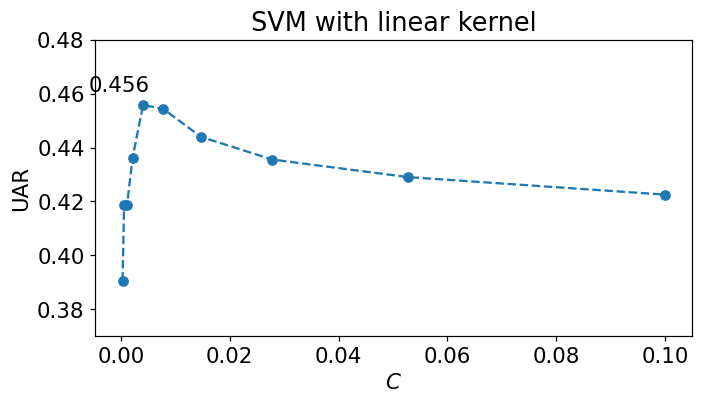

In [15]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

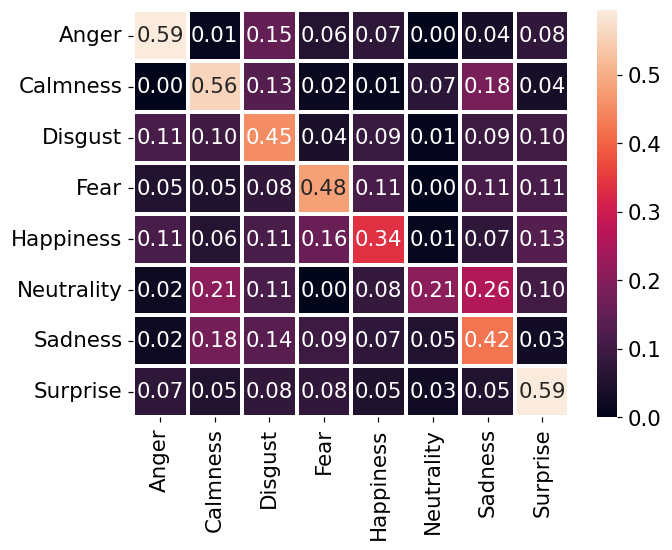

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [16]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [17]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [18]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,0.327919,-0.540508,-0.060487,-0.106014,-0.070218,0.056469,-0.343715,0.172226,-0.340691,0.507975,...,1.463552,0.189168,0.394309,-0.281787,0.524415,1.045982,0.987905,-0.246103,3.179845,0.245317
1,-0.483370,0.073293,-1.253454,-0.757471,-0.863949,-0.799678,-0.223590,0.613144,-0.762145,-0.578013,...,-0.068275,-0.874247,-0.672824,-0.370472,-1.225511,1.095423,-0.583977,-0.055534,0.898781,-0.156659
2,-0.982420,-0.238024,-1.531317,-1.390703,-1.057735,-0.983564,0.311040,0.981156,-0.826127,-0.276989,...,-0.508076,-0.830529,-0.616111,-0.963422,-0.850846,-0.287979,2.394697,-0.613532,1.071862,-0.281905
3,0.968978,-0.123225,-1.943137,0.978390,1.570415,0.483423,-0.494150,-0.562788,-0.165081,0.540148,...,0.906458,-0.047226,-0.287503,0.259688,-0.146225,1.523517,-0.637288,0.924657,1.296904,1.607295
4,0.548798,-0.843281,-1.132945,0.097642,2.117868,0.810331,0.185140,0.343931,0.046708,1.195381,...,1.819556,0.733754,2.594397,-0.109847,0.975002,1.511679,-0.144757,-0.096856,1.478849,-1.016605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.137958,0.014833,-0.841991,0.179815,0.305454,0.463616,-0.587185,0.995423,0.585410,1.267308,...,1.597194,0.426312,2.826095,0.719642,0.542020,0.876186,-0.859015,2.231347,-0.368816,-1.118634
1436,1.705626,-0.992780,-0.996163,1.101439,0.185524,0.580692,1.358758,-0.063867,0.095599,1.304799,...,0.060126,1.362070,0.894283,-0.372309,0.731970,-0.934205,-1.440430,-0.109305,1.549794,-1.340543
1437,0.619210,-0.087927,-0.584423,0.406226,-0.459038,-0.174437,0.358425,0.205071,0.129536,1.806541,...,1.555189,0.280017,0.343901,0.571379,-0.099487,-0.387520,-1.858146,0.951271,0.531691,-1.345549
1438,-0.363270,0.473982,-1.308061,-0.427394,-0.743896,-0.699224,0.302992,1.012529,-0.580327,0.129659,...,-0.481803,0.260939,0.023455,0.377449,0.380642,-0.288413,-0.700458,0.524153,-0.519132,-0.447660


## GridSearch

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.92it/s]

UAR = 0.293


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.45it/s]

UAR = 0.307


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.95it/s]

UAR = 0.313


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.23it/s]

UAR = 0.329


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.94it/s]

UAR = 0.345


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.79it/s]

UAR = 0.365


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.99it/s]

UAR = 0.369


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.41it/s]

UAR = 0.372


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.89it/s]

UAR = 0.383


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.16it/s]

UAR = 0.394


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.49it/s]

UAR = 0.394


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.78it/s]

UAR = 0.391


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.98it/s]

UAR = 0.396


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.18it/s]

UAR = 0.391


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.93it/s]

UAR = 0.390


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.18it/s]

UAR = 0.393


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.20it/s]

UAR = 0.401


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.34it/s]

UAR = 0.404


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.72it/s]

UAR = 0.408


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.99it/s]

UAR = 0.414


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.40it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.57it/s]

UAR = 0.409


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.15it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.00it/s]

UAR = 0.411


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.83it/s]

UAR = 0.403


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.25it/s]

UAR = 0.403


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.05it/s]

UAR = 0.399


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.32it/s]

UAR = 0.393


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.59it/s]

UAR = 0.399


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.83it/s]

UAR = 0.401


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.34it/s]

UAR = 0.394


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.99it/s]

UAR = 0.386


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.68it/s]

UAR = 0.384


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.40it/s]

UAR = 0.380


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.05it/s]

UAR = 0.371


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.48it/s]

UAR = 0.381


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.15it/s]

UAR = 0.368


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.79it/s]

UAR = 0.368


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.25it/s]

UAR = 0.374


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


UAR = 0.374
UAR_best = 0.414, C_best = 0.016


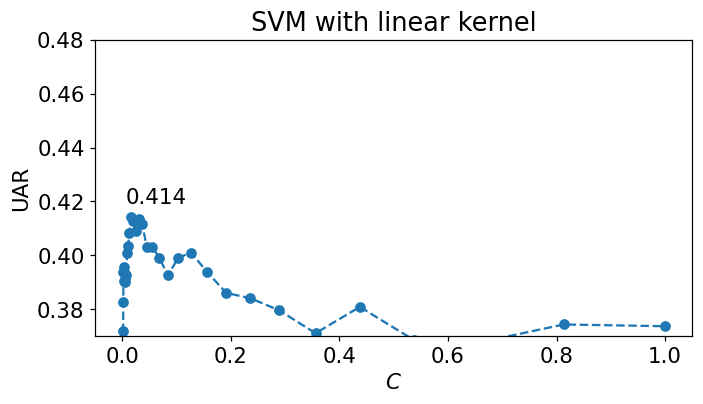

In [19]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

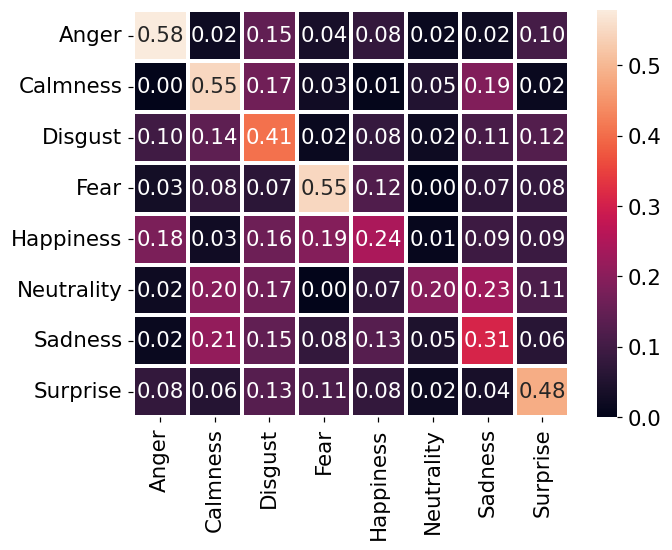

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [20]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)